# Lasso and Ridge Regression

In [1]:
# import libraries 
import pandas as pd 
import numpy as np

## Linear Regression

In [79]:
# Let us first do the simple linear regression (as we have done before)
def linear(X, y):
    p = X.shape[1]
    
    # centralize X and y 
    X_bar = np.mean(X, axis=0)
    X_centred = X - X_bar
    y_centred = y - np.mean(y)
    
    beta = np.dot(
        np.linalg.inv(np.dot(X.T, X)),
        np.dot(X.T, y)
    )
    
    beta_0 = np.mean(y) - np.dot(X_bar, beta)
    
    return beta_0, beta

In [80]:
# Let us run this regression
sales_data = pd.read_csv("../Data/advertising.csv")

# choose X and y
X = sales_data.iloc[:,:-1].to_numpy()
y = sales_data.iloc[:,-1].values

# apply the function
print(Linear(X,y))

(np.float64(0.6753090438350711), array([0.06707876, 0.16003288, 0.02843349]))


# Lasso Regression

In [71]:
import numpy as np
import copy

def soft_th(lambda_, z):
    """Soft thresholding operator."""
    return np.sign(z) * max(abs(z) - lambda_, 0)

def centralize(X, y):
    """Centralize and normalize the data."""
    X_bar = np.mean(X, axis=0)
    X_sd = np.std(X, axis=0)
    X_sd[X_sd == 0] = 1  # Avoid division by zero
    X = (X - X_bar) / X_sd
    y_bar = np.mean(y)
    y = y - y_bar
    return X, y, X_bar, X_sd, y_bar

def linear_lasso(X, y, lam=0, beta=None):
    n, p = X.shape
    if beta is None:
        beta = np.zeros(p)

    # Centralize the data
    X, y, X_bar, X_sd, y_bar = centralize(X, y)

    # Initialize convergence parameters
    eps = 1
    beta_old = copy.copy(beta)

    # Precompute useful quantities
    # Since we have normalized X , this is always equal to a array of ones 
    X_squared_sum = np.sum(X ** 2, axis=0) / n

    while eps > 0.00001:
        # Compute residuals
        r = y - np.dot(X, beta)  # Vectorized computation of residuals

        # Update beta
        for j in range(p):
            r += X[:, j] * beta[j]  # Add contribution of feature j back to residual
            z = np.dot(r, X[:, j]) / n / X_squared_sum[j]
            beta[j] = soft_th(lam, z)
            r -= X[:, j] * beta[j]  # Subtract updated contribution of feature j

        # Check convergence
        eps = np.linalg.norm(beta - beta_old, 2)
        beta_old = copy.copy(beta)

    # Recover the coefficients to the original scale
    beta /= X_sd
    beta_0 = y_bar - np.dot(X_bar, beta)

    return beta, beta_0

Coordinate descent is an iterative optimization method that updates one variable (or coefficient) at a time while keeping others fixed. Here’s a step-by-step explanation of how the coordinate descent method is implemented in the `linear_lasso` function for Lasso regression:

---

### **1. Centralizing and Normalizing the Data**
- **Why?** This step ensures that all features are on the same scale and the intercept is handled separately.
- **Steps:**
  - Compute the mean (`X_bar`) and standard deviation (`X_sd`) of each feature in `X`.
  - Subtract the mean and divide by the standard deviation for each feature to centralize and normalize.
  - Subtract the mean of `y` (`y_bar`) to center the target variable.
- **Result:** 
  - Centralized `X` and `y` ensure no bias from feature scaling or intercept during coefficient updates.

---

### **2. Initialization**
- Set `beta` (coefficients) to zeros if not provided.
- Compute `X_squared_sum`, the precomputed denominator for coefficient updates:
  $
  X\_squared\_sum[j] = \frac{\sum_{i=1}^n X[i, j]^2}{n}
  $
  This avoids recalculating it during each iteration.

---

### **3. Iterative Update Using Coordinate Descent**
The algorithm loops over each coefficient $\beta[j] $ and updates it while keeping other coefficients fixed. This continues until the coefficients converge (i.e., changes are very small).

#### For each feature $ j $:
1. **Compute the Residual:**
   - The residual vector $ r $ represents the difference between the actual target values $ y $ and the predictions made using the current coefficients:
     $
     r = y - X \beta
     $
   - To efficiently update $ \beta[j] $, temporarily **add back** the contribution of feature $ j $ using its current coefficient:
     $
     r = r + X[:, j] \cdot \beta[j]
     $

2. **Compute $ z $:**
   - $ z $ is the value the coefficient would take if there were no regularization:
     $
     \\z = \frac{\text{dot}(r, X[:, j])}{n \cdot X\_squared\_sum[j]}
     $
   - This involves:
     - Computing the dot product of the residual $ r $ and the $ j $-th feature column.
     - Dividing by the normalized sum of squares for feature $ j $.

3. **Apply Soft Thresholding:**
   - Update $ \beta[j] $ using the **soft-thresholding operator**:
     $
     \beta[j] = \text{sign}(z) \cdot \max(|z| - \lambda, 0)
     $
   - This step enforces sparsity (sets coefficients close to zero if $ \lambda $ is large).

4. **Update Residuals:**
   - After computing $ \beta[j] $, subtract its new contribution from the residual:
     $
     r = r - X[:, j] \cdot \beta[j]
     $

#### Convergence Check:
- Compute the change in coefficients:
  $
  \text{eps} = ||\beta - \beta\_old||_2
  $
- If $ \text{eps} $ is smaller than the threshold (e.g., $ 10^{-5} $), stop iterating.

---

### **4. Recovering Coefficients**
Once the loop converges:
- Scale the coefficients back to their original scale:
  $
  \beta[j] = \frac{\beta[j]}{X\_sd[j]}
  $
- Compute the intercept:
  $
  \beta_0 = y\_bar - \sum_{j=1}^p X\_bar[j] \cdot \beta[j]
  $

---

### **5. Output**
- **$ \beta $:** Final coefficients for each feature.
- **$ \beta_0 $:** The intercept term.

---

### **Example Walkthrough**
#### Input:
- $ X $: 3 features, 5 samples.
- $ y $: Target values.
- $ \lambda = 0.1 $.

#### Iteration:
- Start with $ \beta = [0, 0, 0] $.
- For each feature $ j $:
  - Update $ r $ to include/exclude $ j $'s contribution.
  - Compute $ z $.
  - Update $ \beta[j] $ using soft thresholding.
  - Adjust $ r $ for the next feature.

#### Convergence:
- After several passes over all features, $ \beta $ stabilizes, and the loop ends.

---

### **Why Coordinate Descent?**
- **Efficient:** Only one coefficient is updated at a time, making it suitable for high-dimensional data.
- **Simple Implementation:** Easy to break the optimization problem into manageable parts.
- **Sparse Solutions:** The soft-thresholding operator promotes sparsity, which is ideal for Lasso regression.

In [72]:
# let us now apply the lasso regression on the data 
linear_lasso(X,y)

(array([0.05444578, 0.10700125, 0.00033565]), np.float64(4.625123873651955))

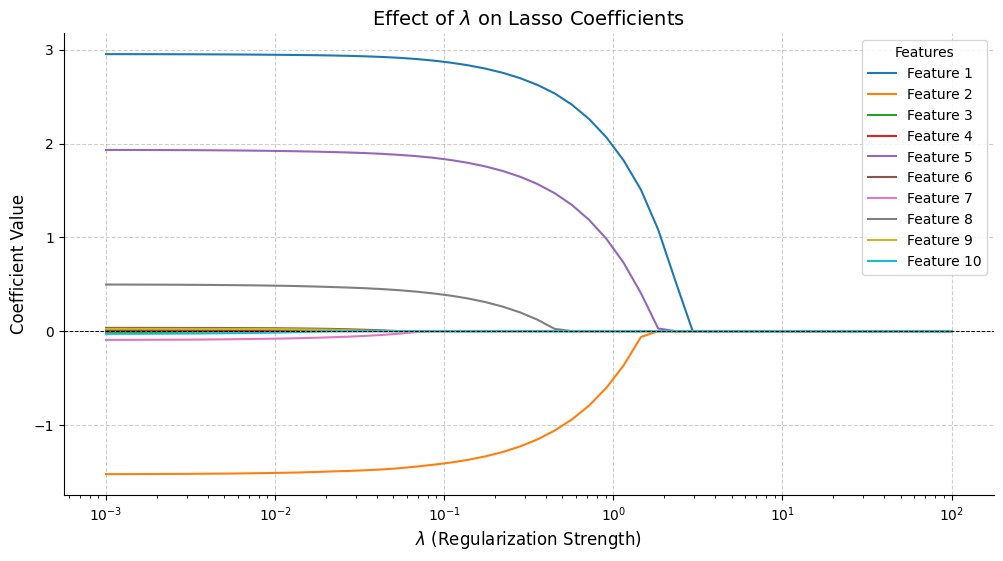

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate synthetic data
np.random.seed(42)
n_samples, n_features = 100, 10
X = np.random.randn(n_samples, n_features)
true_beta = np.array([3, -1.5, 0, 0, 2, 0, 0, 0.5, 0, 0])  # Sparse coefficients
y = X @ true_beta + np.random.randn(n_samples) * 0.5  # Add noise

# Define range of lambda values
lambda_values = np.logspace(-3, 2, 50)  # Logarithmic range from 0.001 to 100
coefficients = []

# Run linear_lasso for each lambda
for lam in lambda_values:
    beta, beta_0 = linear_lasso(X, y, lam=lam)
    coefficients.append(beta)

# Convert coefficients to a numpy array for easier handling
coefficients = np.array(coefficients)

# Set up a Matplotlib figure using object-oriented approach
fig, ax = plt.subplots(figsize=(12, 6))

# Plot coefficients against lambda values
for i in range(coefficients.shape[1]):  # Loop through features
    ax.plot(lambda_values, coefficients[:, i], label=f"Feature {i+1}")

# Customize the plot
ax.set_xscale('log')  # Log scale for lambda
ax.set_xlabel('$\\lambda$ (Regularization Strength)', fontsize=12)
ax.set_ylabel('Coefficient Value', fontsize=12)
ax.set_title('Effect of $\\lambda$ on Lasso Coefficients', fontsize=14)
ax.axhline(0, color='black', linestyle='--', linewidth=0.7)  # Zero reference line
ax.legend(loc='best', title='Features')
ax.grid(True, linestyle='--', alpha=0.6)

# Show plot
sns.despine()
plt.show()

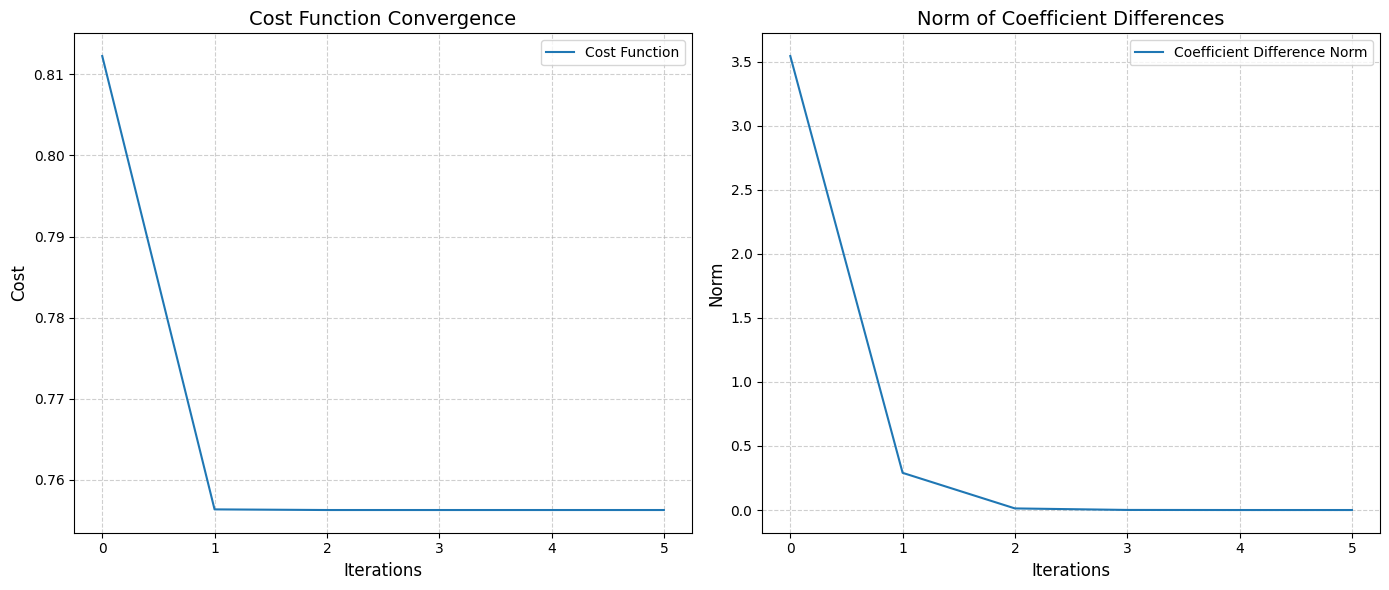

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import copy

def soft_th(lambda_, z):
    """Soft thresholding operator."""
    return np.sign(z) * max(abs(z) - lambda_, 0)

def centralize(X, y):
    """Centralize and normalize the data."""
    X_bar = np.mean(X, axis=0)
    X_sd = np.std(X, axis=0)
    X_sd[X_sd == 0] = 1  # Avoid division by zero
    X = (X - X_bar) / X_sd
    y_bar = np.mean(y)
    y = y - y_bar
    return X, y, X_bar, X_sd, y_bar

def linear_lasso_convergence(X, y, lam=0, beta=None):
    n, p = X.shape
    if beta is None:
        beta = np.zeros(p)

    # Centralize the data
    X, y, X_bar, X_sd, y_bar = centralize(X, y)

    # Initialize convergence parameters
    eps = 1
    beta_old = copy.copy(beta)

    # Precompute useful quantities
    X_squared_sum = np.sum(X ** 2, axis=0) / n

    # Track convergence metrics
    cost_values = []
    beta_diff_norms = []

    while eps > 0.00001:
        # Compute residuals
        r = y - np.dot(X, beta)  # Vectorized computation of residuals

        # Update beta
        for j in range(p):
            r += X[:, j] * beta[j]  # Add contribution of feature j back to residual
            z = np.dot(r, X[:, j]) / n / X_squared_sum[j]
            beta[j] = soft_th(lam, z)
            r -= X[:, j] * beta[j]  # Subtract updated contribution of feature j

        # Track cost function
        residuals = y - np.dot(X, beta)
        cost = (1 / (2 * n)) * np.sum(residuals ** 2) + lam * np.sum(np.abs(beta))
        cost_values.append(cost)

        # Track beta difference norm
        eps = np.linalg.norm(beta - beta_old, 2)
        beta_diff_norms.append(eps)

        # Update old beta
        beta_old = copy.copy(beta)

    return beta, beta_diff_norms, cost_values

# Generate synthetic data
np.random.seed(42)
n_samples, n_features = 100, 10
X = np.random.randn(n_samples, n_features)
true_beta = np.array([3, -1.5, 0, 0, 2, 0, 0, 0.5, 0, 0])  # Sparse coefficients
y = X @ true_beta + np.random.randn(n_samples) * 0.5  # Add noise

# Run linear_lasso_convergence for a fixed lambda
lambda_value = 0.1
beta, beta_diff_norms, cost_values = linear_lasso_convergence(X, y, lam=lambda_value)

# Plot convergence metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot cost function
axes[0].plot(cost_values, label="Cost Function")
axes[0].set_xlabel("Iterations", fontsize=12)
axes[0].set_ylabel("Cost", fontsize=12)
axes[0].set_title("Cost Function Convergence", fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()

# Plot norm of coefficient differences
axes[1].plot(beta_diff_norms, label="Coefficient Difference Norm")
axes[1].set_xlabel("Iterations", fontsize=12)
axes[1].set_ylabel("Norm", fontsize=12)
axes[1].set_title("Norm of Coefficient Differences", fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

## Ridge Regression

In [82]:
import numpy as np

def ridge_regression(X, y, lam=0.1, lr=0.01, max_iter=1000, tol=1e-6):
    """
    Perform Ridge Regression using Gradient Descent.

    Parameters:
        X (ndarray): Feature matrix of shape (n_samples, n_features).
        y (ndarray): Target vector of shape (n_samples,).
        lam (float): Regularization parameter (lambda).
        lr (float): Learning rate for gradient descent.
        max_iter (int): Maximum number of iterations for gradient descent.
        tol (float): Tolerance for convergence.

    Returns:
        beta (ndarray): Coefficients of shape (n_features,).
        beta_0 (float): Intercept term.
    """
    # Centralize data
    X_bar = np.mean(X, axis=0)
    X_sd = np.std(X, axis=0)
    X_sd[X_sd == 0] = 1  # Avoid division by zero
    X = (X - X_bar) / X_sd
    y_bar = np.mean(y)
    y = y - y_bar

    n, p = X.shape
    beta = np.zeros(p)  # Initialize coefficients

    # Gradient Descent
    for i in range(max_iter):
        y_pred = X @ beta  # Compute predictions
        gradient = (-1 / n) * (X.T @ (y - y_pred)) + lam * beta  # Compute gradient
        beta_new = beta - lr * gradient  # Update coefficients

        # Check for convergence
        if np.linalg.norm(beta_new - beta, 2) < tol:
            break
        beta = beta_new

    # Recover original scale
    beta /= X_sd
    beta_0 = y_bar - np.dot(X_bar, beta)

    return beta, beta_0

Here’s a function to perform Ridge Regression using gradient descent. Ridge regression minimizes the following objective function:

$
J(\beta) = \frac{1}{2n} \|y - X\beta\|_2^2 + \frac{\lambda}{2} \|\beta\|_2^2
$

This adds an $ \ell_2 $-norm penalty to the coefficients to prevent overfitting and shrink coefficients toward zero.

### Explanation
1. **Initialization**:
   - Centralize $ X $ and $ y $ to simplify computations and avoid bias in the intercept term.

2. **Gradient Descent**:
   - Compute the gradient:
     $
     \nabla_\beta J(\beta) = -\frac{1}{n} X^\top (y - X\beta) + \lambda \beta
     $
   - Update the coefficients using:
     $
     \beta^{(k+1)} = \beta^{(k)} - \eta \nabla_\beta J(\beta)
     $
     where $ \eta $ is the learning rate.

3. **Convergence**:
   - Check for convergence by monitoring the change in coefficients $ \|\beta^{(k+1)} - \beta^{(k)}\|_2 $.

4. **Recover Original Scale**:
   - Scale back the coefficients to their original scale after normalization.

In [83]:
ridge_regression(X,y)

(array([ 2.68907097, -1.35823251,  0.01977625, -0.02110479,  1.73468943,
         0.0842147 , -0.07321125,  0.45756495,  0.10879226,  0.01592919]),
 np.float64(0.10173475906517607))

In [84]:
import numpy as np

def ridge(X, y, lam=0):
    """
    Perform Ridge Regression using the closed-form solution.

    Parameters:
        X (ndarray): Feature matrix of shape (n_samples, n_features).
        y (ndarray): Target vector of shape (n_samples,).
        lam (float): Regularization parameter (lambda).

    Returns:
        beta (ndarray): Coefficients of shape (n_features,).
        beta_0 (float): Intercept term.
    """
    # Number of samples and features
    n, p = X.shape

    # Centralize the data
    X, y, X_bar, X_sd, y_bar = centralize(X, y)

    # Compute Ridge Regression coefficients
    beta = np.dot(
        np.linalg.inv(np.dot(X.T, X) + n * lam * np.eye(p)),
        np.dot(X.T, y)
    )

    # Recover coefficients to the original scale
    beta = beta / X_sd
    beta_0 = y_bar - np.dot(X_bar, beta)

    return beta, beta_0

This implementation of **Ridge Regression** uses the closed-form solution to minimize the Ridge loss:

$
J(\beta) = \frac{1}{2n} \|y - X\beta\|_2^2 + \frac{\lambda}{2} \|\beta\|_2^2
$

The closed-form solution for Ridge Regression is:

$
\beta = \left(X^T X + n \lambda I \right)^{-1} X^T y
$

### Explanation of the Code

1. **Input Parameters**:
   - `X`: Feature matrix of shape $(n \times p)$.
   - `y`: Target vector of shape $n,)$.
   - `lam`: Regularization parameter ($lambda$).

2. **Centralization**:
   - The `centralize` function adjusts the data to zero-mean for $X$ and $y$, and scales $X$ by standard deviation.

3. **Closed-Form Solution**:
   - Compute the coefficient vector $\beta $ using:
     $
     \beta = \left(X^T X + n \lambda I \right)^{-1} X^T y
     $
     Here, $ is the identity matrix scaled by the regularization parameter $n \lambda$.

4. **Recovery of Coefficients**:
   - After solving for $ \beta $, scale it back to the original data space.

5. **Intercept Term**:
   - Compute the intercept $ \beta_0 $ using:
     $
     \beta_0 = \bar{y} - \bar{X} \cdot \beta
     $


### Benefits of the Ridge Closed-Form Approach

1. **Efficient for Small Datasets**:
   - The closed-form solution is computationally efficient for small to medium-sized datasets.

2. **Regularization**:
   - The regularization term $ \lambda $ prevents overfitting by shrinking coefficients.

3. **Avoids Multicollinearity**:
   - Adding $\lambda I $ helps stabilize the inversion of $X^T X $ if it is nearly singular.